In [1]:
!pip install playwright
!python -m playwright install



In [2]:
import nest_asyncio
nest_asyncio.apply()


In [3]:
import asyncio
from playwright.async_api import async_playwright
import csv
import os
from bs4 import BeautifulSoup
import re
import time

HASHTAGS = ["ghibliAI", "PixarAI"]
MAX_POSTS = 10
STORAGE = "insta_auth.json"
OUTPUT_FILE = "ghibli_trend_data.csv"

async def login_and_save_session(page):
    print("🔐 Please log in manually in the browser window...")
    await page.goto("https://www.instagram.com/accounts/login/")
    # Wait for login or until redirected to main page
    await page.wait_for_selector("nav", timeout=120000)  # 2 minutes to log in
    print("💾 Saving session...")

async def scrape_instagram(hashtags, max_posts):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        
        # Create a persistent context with more realistic viewport
        context = await browser.new_context(
            storage_state=STORAGE if os.path.exists(STORAGE) else None,
            viewport={"width": 1280, "height": 800},
            user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        )
        
        page = await context.new_page()
        
        # Login if needed
        if not os.path.exists(STORAGE):
            await login_and_save_session(page)
            await context.storage_state(path=STORAGE)
        else:
            # Verify we're logged in
            await page.goto("https://www.instagram.com/")
            await page.wait_for_timeout(5000)
            
            # If redirected to login, we need to log in again
            if "/accounts/login" in page.url:
                print("⚠️ Session expired, please log in again...")
                await login_and_save_session(page)
                await context.storage_state(path=STORAGE)
        
        data = []
        for hashtag in hashtags:
            print(f"\n🔍 Scraping #{hashtag}...")
            try:
                # Try direct hashtag URL
                tag_url = f"https://www.instagram.com/explore/tags/{hashtag}/"
                await page.goto(tag_url)
                await page.wait_for_timeout(8000)  # Increased wait time
                
                # Check if we were redirected to search
                if "/explore/search/" in page.url:
                    print(f"⚠️ Redirected to search page. Trying alternative approach...")
                    
                    # Try to click on the hashtag in search results
                    try:
                        # Wait for search results to appear
                        await page.wait_for_selector('div[role="none"] > a', timeout=15000)
                        await page.wait_for_timeout(2000)
                        
                        # Click the first result that looks like a hashtag page
                        hashtag_links = await page.query_selector_all('div[role="none"] > a')
                        clicked = False
                        for link in hashtag_links:
                            href = await link.get_attribute('href')
                            if href and '/explore/tags/' in href:
                                await link.click()
                                clicked = True
                                await page.wait_for_timeout(5000)
                                break
                        
                        if not clicked:
                            raise Exception("Could not find hashtag in search results")
                    except Exception as e:
                        print(f"⚠️ Failed to navigate from search: {e}")
                
                # Try multiple selectors to find posts
                selectors = [
                    "article a", 
                    "article div > a", 
                    "div[role='dialog'] a",
                    "main article a",
                    "div._aagw a"  # Instagram sometimes uses this class
                ]
                
                post_links = []
                for selector in selectors:
                    try:
                        print(f"Trying selector: {selector}")
                        await page.wait_for_selector(selector, timeout=5000)
                        found_links = await page.eval_on_selector_all(
                            selector, 
                            "els => els.filter(e => e.href && e.href.includes('/p/')).map(e => e.href)"
                        )
                        if found_links and len(found_links) > 0:
                            post_links = found_links
                            print(f"✅ Found {len(post_links)} posts with selector: {selector}")
                            break
                    except Exception as e:
                        print(f"Selector '{selector}' failed: {e}")
                
                if not post_links:
                    # As a fallback, try to extract hrefs containing "/p/" from page content
                    html = await page.content()
                    soup = BeautifulSoup(html, "html.parser")
                    all_links = soup.find_all("a", href=True)
                    post_links = [link["href"] for link in all_links if "/p/" in link["href"]]
                    if post_links:
                        # Ensure they're full URLs
                        post_links = [link if link.startswith("http") else f"https://www.instagram.com{link}" for link in post_links]
                        print(f"✅ Found {len(post_links)} posts via HTML parsing")
                
                if not post_links:
                    raise Exception("Could not find any posts")
                
                # Remove duplicates and limit
                selected_links = list(dict.fromkeys(post_links))[:max_posts]
                print(f"🔗 Processing {len(selected_links)} unique posts")
                
                for link in selected_links:
                    try:
                        await page.goto(link)
                        await page.wait_for_timeout(3000)
                        
                        # Wait for post content to load, try multiple selectors
                        post_selectors = ["article", "div[role='dialog']", "section main"]
                        for selector in post_selectors:
                            try:
                                await page.wait_for_selector(selector, timeout=5000)
                                break
                            except:
                                continue
                        
                        html = await page.content()
                        soup = BeautifulSoup(html, "html.parser")
                        
                        # Extract caption - try multiple approaches
                        caption = ""
                        hashtags_found = []
                        
                        # Method 1: og:description meta tag
                        caption_tag = soup.find("meta", {"property": "og:description"})
                        if caption_tag and caption_tag.get("content"):
                            caption = caption_tag["content"]
                        
                        # Method 2: Look for text in specific elements
                        if not caption:
                            caption_elements = soup.select("div._a9zs, div._a9zm, span._aacl")
                            if caption_elements:
                                caption = caption_elements[0].text
                        
                        # Extract hashtags from caption
                        if caption:
                            hashtags_found = re.findall(r"#\w+", caption)
                        
                        # Try to find likes count
                        likes = ""
                        like_elements = soup.select("section._ae5m span, span._aacl")
                        for el in like_elements:
                            text = el.text.strip()
                            if re.search(r"\d+\s*likes", text.lower()):
                                likes = text
                                break
                        
                        data.append({
                            "hashtag": hashtag,
                            "post_url": link,
                            "caption": caption,
                            "likes": likes,
                            "hashtags_found": ", ".join(hashtags_found)
                        })
                        print(f"✅ Scraped: {link}")
                        
                        # Add a delay between posts to avoid rate limiting
                        await page.wait_for_timeout(2000 + (1000 * (len(data) % 3)))
                        
                    except Exception as e:
                        print(f"⚠️ Failed to scrape post {link}: {e}")
                
            except Exception as e:
                print(f"❌ Failed for #{hashtag}: {e}")
                print(f"📄 Current page URL: {page.url}")
                
                # Take a screenshot for debugging
                await page.screenshot(path=f"debug_{hashtag}.png")
                print(f"📸 Debug screenshot saved as debug_{hashtag}.png")
        
        if data:
            with open(OUTPUT_FILE, mode="w", newline="", encoding="utf-8") as file:
                writer = csv.DictWriter(file, fieldnames=data[0].keys())
                writer.writeheader()
                writer.writerows(data)
            print(f"\n✅ Data saved to {OUTPUT_FILE}")
        else:
            print("\n⚠️ No data scraped. CSV file not created.")
        
        await browser.close()

# Run it inside Jupyter or standalone
await scrape_instagram(HASHTAGS, MAX_POSTS)


🔍 Scraping #ghibliAI...
⚠️ Redirected to search page. Trying alternative approach...
⚠️ Failed to navigate from search: Page.wait_for_selector: Timeout 15000ms exceeded.
Call log:
  - waiting for locator("div[role=\"none\"] > a") to be visible

Trying selector: article a
Selector 'article a' failed: Page.wait_for_selector: Timeout 5000ms exceeded.
Call log:
  - waiting for locator("article a") to be visible

Trying selector: article div > a
Selector 'article div > a' failed: Page.wait_for_selector: Timeout 5000ms exceeded.
Call log:
  - waiting for locator("article div > a") to be visible

Trying selector: div[role='dialog'] a
Selector 'div[role='dialog'] a' failed: Page.wait_for_selector: Timeout 5000ms exceeded.
Call log:
  - waiting for locator("div[role='dialog'] a") to be visible

Trying selector: main article a
Selector 'main article a' failed: Page.wait_for_selector: Timeout 5000ms exceeded.
Call log:
  - waiting for locator("main article a") to be visible

Trying selector: div

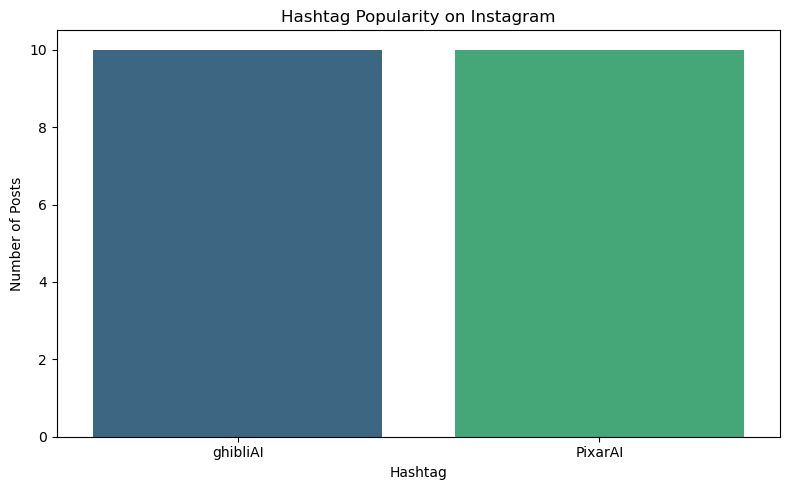

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the scraped CSV
df = pd.read_csv("ghibli_trend_data.csv")

# Count how many posts for each hashtag
hashtag_counts = df['hashtag'].value_counts().reset_index()
hashtag_counts.columns = ['hashtag', 'Post Count']

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(
    data=hashtag_counts,
    x='hashtag',
    y='Post Count',
    hue='hashtag',        # Needed for palette
    palette='viridis',
    legend=False          # Hide legend to avoid redundancy
)

plt.title('Hashtag Popularity on Instagram')
plt.xlabel('Hashtag')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()


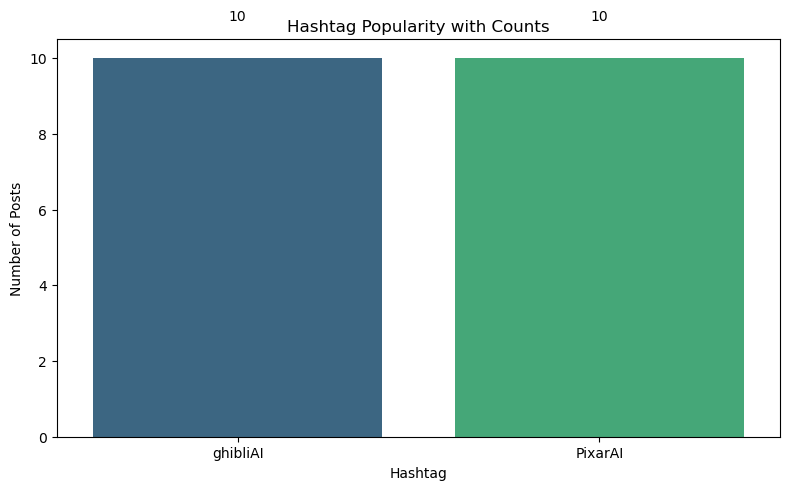

In [32]:
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    data=hashtag_counts,
    x='hashtag',
    y='Post Count',
    hue='hashtag',
    palette='viridis',
    legend=False  # removes legend since hue is redundant here
)

# Add count labels on top of bars
for index, row in hashtag_counts.iterrows():
    barplot.text(index, row['Post Count'] + 1, row['Post Count'], color='black', ha="center")

plt.title('Hashtag Popularity with Counts')
plt.xlabel('Hashtag')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()


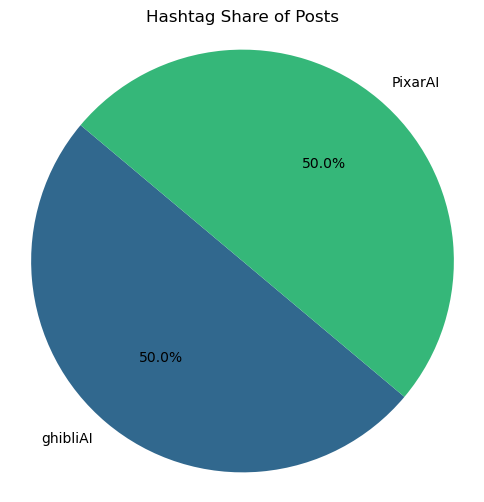

In [34]:
plt.figure(figsize=(6, 6))
plt.pie(
    hashtag_counts['Post Count'],
    labels=hashtag_counts['hashtag'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('viridis', len(hashtag_counts))
)
plt.title('Hashtag Share of Posts')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()



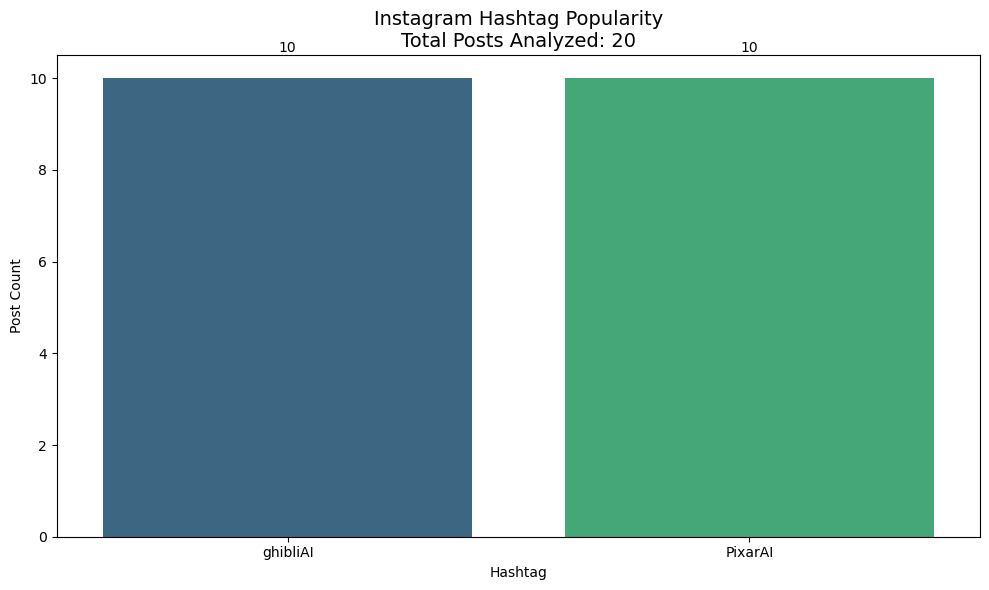

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV
df = pd.read_csv("ghibli_trend_data.csv")

# Count posts per hashtag
hashtag_counts = df['hashtag'].value_counts().reset_index()
hashtag_counts.columns = ['hashtag', 'Post Count']
total_posts = hashtag_counts['Post Count'].sum()

# Plot donut chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette('viridis', len(hashtag_counts))

# Create donut-style pie chart
plt.pie(
    hashtag_counts['Post Count'],
    labels=hashtag_counts['hashtag'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4)  # This makes it a donut
)

# Title with total posts
plt.title(f"Hashtag Popularity on Instagram\nTotal Posts: {total_posts}", fontsize=14)
plt.axis('equal')  # Ensures circle shape
plt.tight_layout()
plt.show()


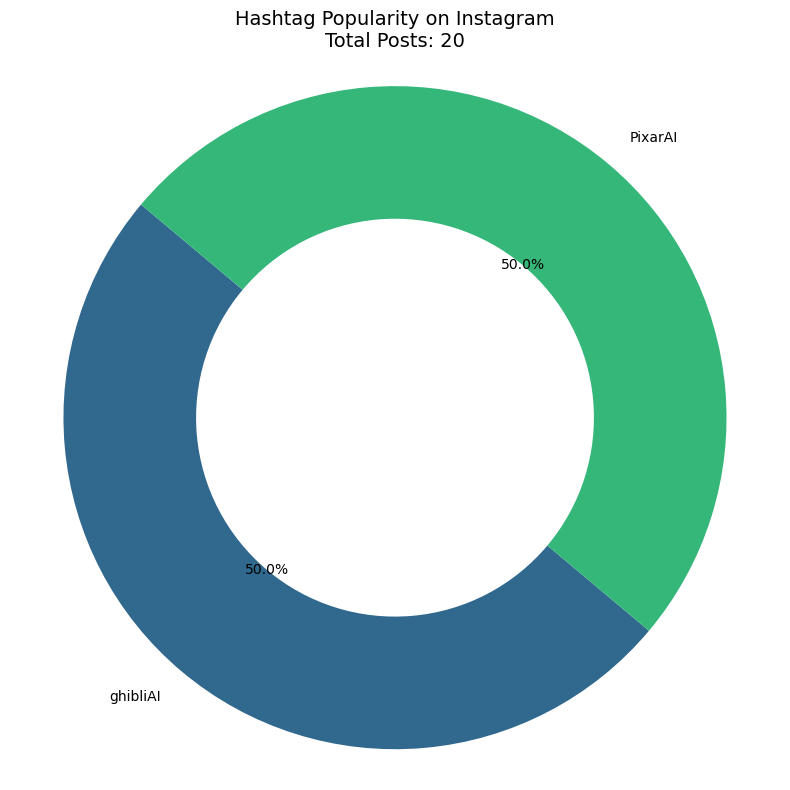

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV
df = pd.read_csv("ghibli_trend_data.csv")

# Count posts per hashtag
hashtag_counts = df['hashtag'].value_counts().reset_index()
hashtag_counts.columns = ['hashtag', 'Post Count']
total_posts = hashtag_counts['Post Count'].sum()

# Plot donut chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette('viridis', len(hashtag_counts))

# Create donut-style pie chart
plt.pie(
    hashtag_counts['Post Count'],
    labels=hashtag_counts['hashtag'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4)  # This makes it a donut
)

# Title with total posts
plt.title(f"Hashtag Popularity on Instagram\nTotal Posts: {total_posts}", fontsize=14)
plt.axis('equal')  # Ensures circle shape
plt.tight_layout()
plt.show()
